## Подключение библиотек 

In [1]:
from IPython.display import Latex
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from numpy import linalg as LA
from time import time 
np.set_printoptions(precision=4)

from sklearn import metrics
from sklearn.datasets import load_diabetes, make_classification, make_blobs
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder, OneHotEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, plot_roc_curve, plot_precision_recall_curve

## Часть 1. Линейная регрессия

**Задание 1.** Обучение линейной регрессии.\
**(1 балл)**
Обучите линейную регрессию с $L_1$ (Lasso) и $L_2$ (Ridge) регуляризаторами (используйте параметры по умолчанию). Посмотрите, какое количество коэффициентов (веса, они же составляют вектор w) близко к 0 (степень близости к 0 определите сами из разумных пределов). Постройте график зависимости числа ненулевых коэффициентов от коэффицента регуляризации (перебирайте значения по логарифмической сетке от $10^{-3}$ до $10^3$). Согласуются ли результаты с вашими ожиданиями?


Для начала загрузим данные и разделим их на обучающую и тестовую выборки в соотношении 7 к 3.

In [87]:
data = load_diabetes(as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

In [88]:
df = data.data
target = data.target

Изучим матрицу корреляции признаков:

0.8966629578104909 -0.7384927292583836 0.035276819175529245


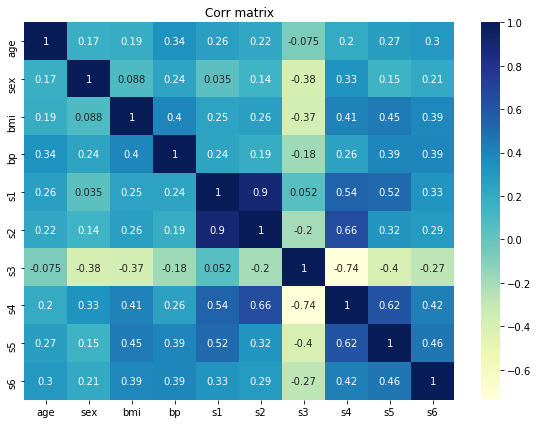

In [4]:
plt.figure(figsize=(8, 6))
corrmat = df.corr()
sn.heatmap(corrmat, annot = True, cmap ="YlGnBu") 
plt.title('Corr matrix')
plt.tight_layout()

corrmat = np.asarray(corrmat)
max_ = corrmat[corrmat < 1].max()
min_ = corrmat.min()
zero_ = abs(corrmat).min()
print (max_, min_, zero_)

Визуализируем зависимость между признаками с самым высоким коэффициентом корреляции, самым низким и самым ближайшим к нулю соответственно.

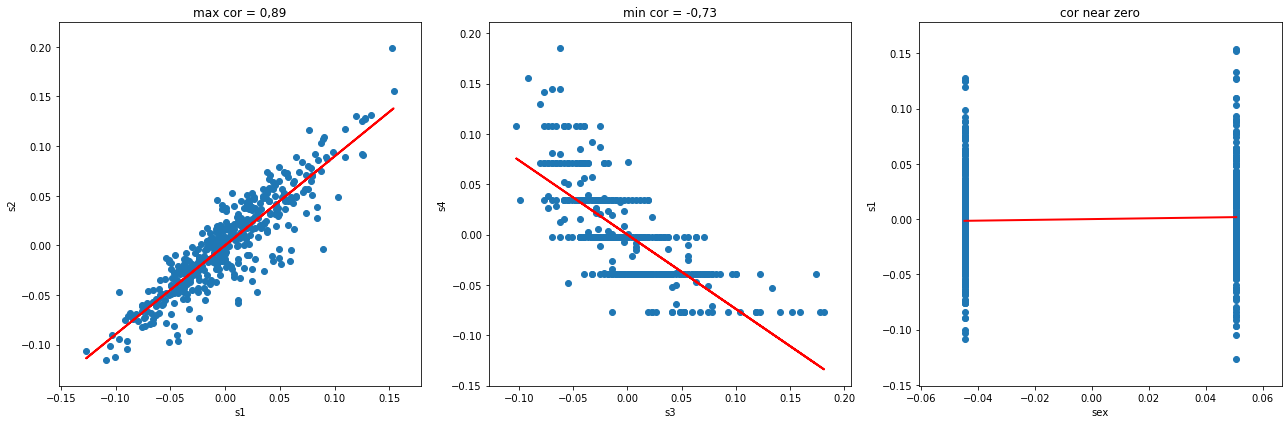

In [5]:
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131)
X = df[['s1']].values
y = df['s2'].values
lr = LinearRegression()
lr.fit(X, y)
ax1.scatter(X, y)
ax1.plot(X, lr.predict(X), color='red', linewidth=2);
ax1.set(xlabel='s1', ylabel='s2', title='max cor = 0,89')

ax2 = fig.add_subplot(132)
X = df[['s3']].values
y = df['s4'].values
lr = LinearRegression()
lr.fit(X, y)
ax2.scatter(X, y)
ax2.plot(X, lr.predict(X), color='red', linewidth=2);
ax2.set(xlabel='s3', ylabel='s4', title='min cor = -0,73')

ax3 = fig.add_subplot(133)
X = df[['sex']].values
y = df['s1'].values
lr = LinearRegression()
lr.fit(X, y)
ax3.scatter(X, y)
ax3.plot(X, lr.predict(X), color='red', linewidth=2);
ax3.set(xlabel='sex', ylabel='s1', title='cor near zero')

plt.tight_layout()

Как видно на первом рисунке, признаки с корреляцией, близкой к 1 отлично линеаризованы. 

Визуализируем предсказания алгоритма. 

In [6]:
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

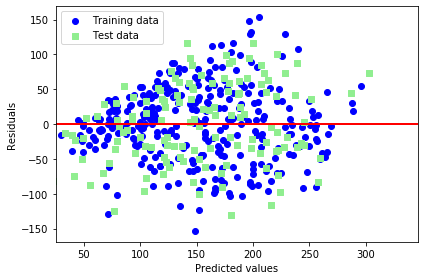

In [8]:
plt.scatter(y_train_pred,  y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=target.min(), xmax=target.max(), lw=2, color='red')
plt.xlim([target.min(), target.max()])
plt.tight_layout()

Видим, что плотность в окрестности прямой 0 крайне невелика, что говорит о больших ошибках алгоритма (в некоторых случаях более 100%)

Прежде чем воспользоваться регуляризацией, необходимо стандартизировать данные: центрировать и нормализовать (вычитание дисперсии и деление на норму). Так будут получены правильные веса с помощью регуляризации. Шкалирование - обязательная процедура. Используем встроеннный StandartScaler.

In [9]:
sc_x = StandardScaler()
X_train_scaled = sc_x.fit_transform(X_train)
X_test_scaled = sc_x.fit_transform(X_test)
y_train_scaled = sc_x.fit_transform(y_train.to_frame()).flatten()
y_test_scaled = sc_x.fit_transform(y_test.to_frame()).flatten()

Применим регуляризации 
1) Lasso(L1-норма по Тихонову): $\|Xw - y\|^2_2 + \alpha\|w\|^2_1 \rightarrow \min{w}$ \
2) Ridge (L2-норма по Тихонову): $\|Xw - y\|^2_2 + \alpha\|w\|^2_2 \rightarrow \min{w}$ \
с параметрами $\alpha = 10^{-3}, 10^{-2,5}, ..., 10^3 $ последовательно. 

Снимем зависимость от $\alpha$ весов $w$, количества близких к нулю $w$, а так же функции ошибок LossFunc и оценок качетсва $RMSE, MAE, R2$

In [92]:
lasso_results = []
ridge_results = []

for a in np.arange(-3, 3.5, 0.5):
    lasso = Lasso(alpha=np.power(10, a))
    ridge = Ridge(alpha=np.power(10, a))
    
    lasso.fit(X_train_scaled, y_train_scaled)
    ridge.fit(X_train_scaled, y_train_scaled)

    y_train_pred_lasso = lasso.predict(X_train_scaled)
    y_test_pred_lasso = lasso.predict(X_test_scaled)  
    y_train_pred_ridge = ridge.predict(X_train_scaled)
    y_test_pred_ridge = ridge.predict(X_test_scaled)
    
    lasso_results.append({
        'alpha': a,
        'coef': lasso.coef_,
        'low_coef': np.count_nonzero(abs(lasso.coef_) < 0.01),
        'LossFunc': abs(mean_squared_error(y_train_scaled, y_train_pred_lasso) + 
                   LA.norm(lasso.coef_) * a),
        'RMSE': mean_squared_error(y_train_scaled, y_train_pred_lasso),
        'MAE': mean_absolute_error(y_train_scaled, y_train_pred_lasso),
        'R2': r2_score(y_train_scaled, y_train_pred_lasso)
    })
    
    ridge_results.append({
        'alpha': a,
        'coef': ridge.coef_,
        'low_coef': np.count_nonzero(abs(ridge.coef_) < 0.01),
        'LossFunc': abs(mean_squared_error(y_train_scaled, y_train_pred_ridge) + 
                   LA.norm(ridge.coef_) * a),
        'RMSE': mean_squared_error(y_train_scaled, y_train_pred_ridge),
        'MAE': mean_absolute_error(y_train_scaled, y_train_pred_ridge),
        'R2': r2_score(y_train_scaled, y_train_pred_ridge)
    })

Распакуем данные в удобный формат для построения графиков.

In [93]:
def extract(results):
    alpha = []
    coef = []
    low_coef = []
    LF = []
    RMSE = []
    MAE = []
    R2 = []
    for r in results:
        alpha.append(r['alpha'])
        coef.append(r['coef'])
        low_coef.append(r['low_coef'])
        LF.append(r['LossFunc'])
        RMSE.append(r['RMSE'])
        MAE.append(r['MAE'])
        R2.append(r['R2'])
    return alpha, coef, low_coef, LF, RMSE, MAE, R2

Построим соответсвующие графики.

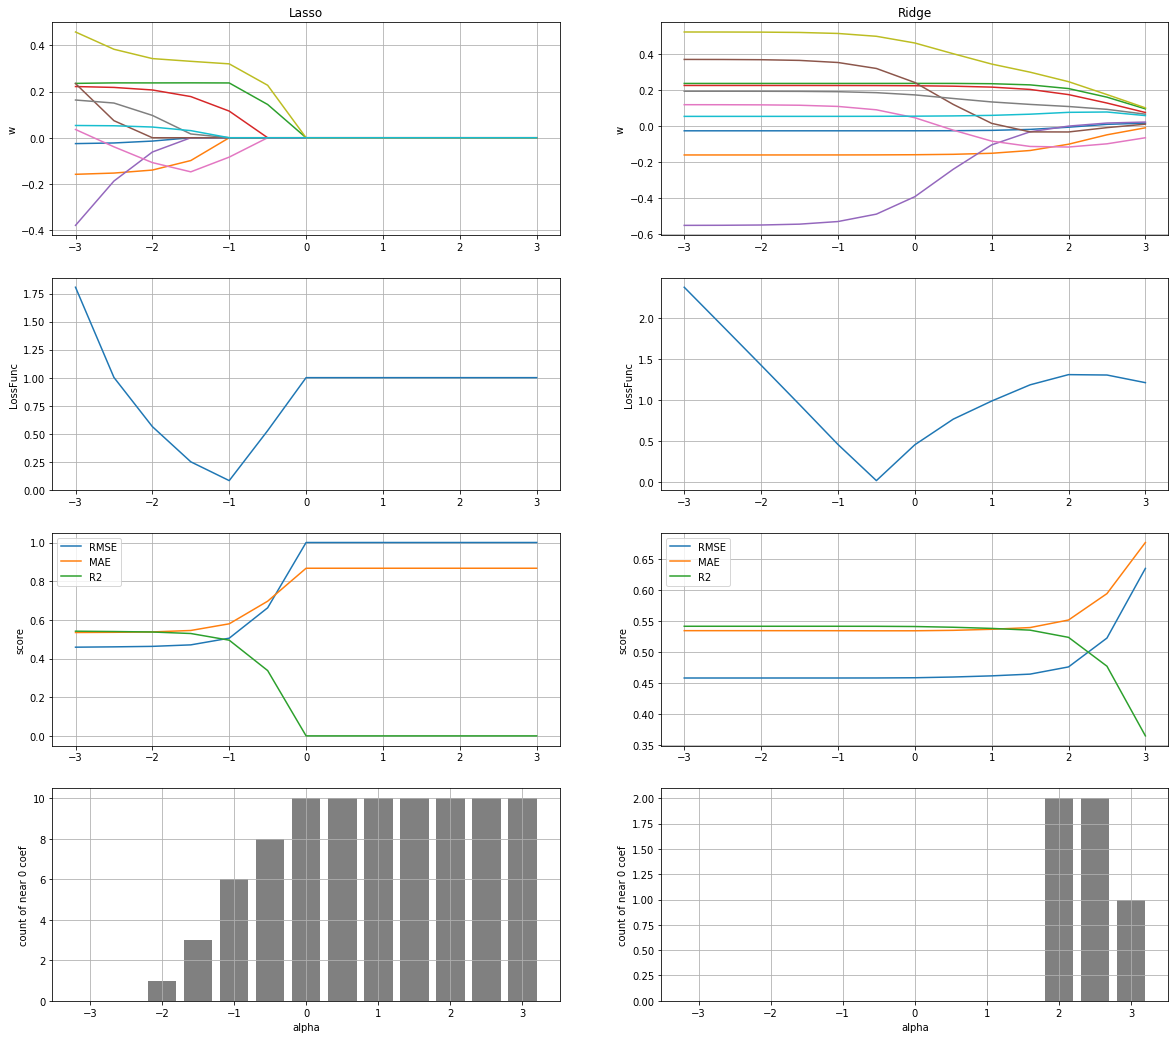

In [94]:
fig = plt.figure(figsize=(20, 18))

####_________Lasso:
alpha, coef, low_coef, LF, RMSE, MAE, R2 = extract(lasso_results)

ax1 = fig.add_subplot(421)
ax1.plot(alpha, coef)
ax1.set(ylabel='w', title='Lasso')
ax1.grid()

ax2 = fig.add_subplot(423)
ax2.plot(alpha, LF)
ax2.set(ylabel='LossFunc')
ax2.grid()

ax3 = fig.add_subplot(425)
ax3.plot(alpha, RMSE, label='RMSE')
ax3.plot(alpha, MAE, label='MAE')
ax3.plot(alpha, R2, label='R2')
ax3.set(ylabel='score')
ax3.legend()
ax3.grid()

ax4 = fig.add_subplot(427)
ax4.bar(alpha, low_coef, width = 0.4, color = 'grey')
ax4.set(xlabel='alpha', ylabel='count of near 0 coef')
ax4.grid()

####_________Ridge:
alpha, coef, low_coef, LF, RMSE, MAE, R2 = extract(ridge_results)

ax5 = fig.add_subplot(422)
ax5.plot(alpha, coef)
ax5.set(ylabel='w', title='Ridge')
ax5.grid()

ax6 = fig.add_subplot(424)
ax6.plot(alpha, LF)
ax6.set(ylabel='LossFunc')
ax6.grid()

ax7 = fig.add_subplot(426)
ax7.plot(alpha, RMSE, label='RMSE')
ax7.plot(alpha, MAE, label='MAE')
ax7.plot(alpha, R2, label='R2')
ax7.set(ylabel='score')
ax7.legend()
ax7.grid()

ax8 = fig.add_subplot(428)
ax8.bar(alpha, low_coef, width = 0.4, color = 'grey')
ax8.set(xlabel='alpha', ylabel='count of near 0 coef')
ax8.grid()

plt.show()

Верхние левый и правый графики отвечают за обнуление весов для Loss и Ridge регуляризации соответственно. Таким образом для Lasso оптимальным параметром можно считать а = 0.1 (6 из 10 весов близки к 0, и функция ошибки достигнет минимума).
У Ridge веса занялются существенно дальше о оси параметра а, потому оптимальный параметр выберем по функции ошибки: а = $10^{-0.5}$
Близость к нулю опредлим границей в 0.01.

Подберем на обучающей выборке для Ridge-регрессии коэффициент регуляризации (перебор параметра $\alpha$ по логарифмической сетке от $10^{-3}$ до $10^3$) для каждой из метрик. Для этого воспользуемся GridSearchCV и KFold из sklearn. Построим графики зависимости фукнции потерь от коэффициента регуляризации. Посчитаем те же метрики снова.
Функцию потерь на выборке (X, y) посчитаем вручную, вытащив коэффициенты из модели и учитывая коэффициент регуляризации $\alpha$.


In [13]:
cv = KFold(n_splits=5, random_state=None, shuffle=False)

In [14]:
best_alpha = []

cv = KFold(n_splits=5, shuffle=True)
grid_param = {'alpha': np.power(10, range(-3, 3), dtype = np.float)}

for estimator in (Lasso(), Ridge()):
    for scoring in ('neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'):
        grid = GridSearchCV(estimator=estimator, param_grid=grid_param, 
                            scoring=scoring, cv=cv)
        grid.fit(X_train_scaled, y_train_scaled)
        best_alpha.append ({
            'estimator': estimator,
            'scoring': scoring,
            'best_alpha': grid.best_params_['alpha'],
            'score': abs(grid.best_score_),
            'score_alpha=1': abs(grid.cv_results_['mean_test_score'][3])
        })

Результат работы:

In [15]:
def compress_1(best_alpha):
    return "{} {} best_alpha: {}  score: {:.3f}".format(
        best_alpha['estimator'],
        best_alpha['scoring'],
        best_alpha['best_alpha'], 
        best_alpha['score']
    )
def compress_2(best_alpha):
    return "alpha=1 score : {:.3f} difference: {:.3f}".format(
        best_alpha['score_alpha=1'],
        best_alpha['score_alpha=1'] - best_alpha['score']
    )

for b_a in best_alpha:
    print(compress_1(b_a), '\n', compress_2(b_a), '\n')

Lasso() neg_root_mean_squared_error best_alpha: 0.001  score: 0.688 
 alpha=1 score : 1.000 difference: 0.312 

Lasso() neg_mean_absolute_error best_alpha: 0.01  score: 0.549 
 alpha=1 score : 0.868 difference: 0.319 

Lasso() r2 best_alpha: 0.01  score: 0.491 
 alpha=1 score : 0.010 difference: -0.480 

Ridge() neg_root_mean_squared_error best_alpha: 10.0  score: 0.699 
 alpha=1 score : 0.700 difference: 0.001 

Ridge() neg_mean_absolute_error best_alpha: 10.0  score: 0.561 
 alpha=1 score : 0.563 difference: 0.002 

Ridge() r2 best_alpha: 0.001  score: 0.487 
 alpha=1 score : 0.487 difference: -0.001 



В результате видим, что для Lasso RMSE и MSE при меньшем параметре стали лучше, а вот R2 наоборот увеличилась. Для Ridge-регрессии это оказалось неважно, то есть $\alpha$ = 1 является оптимальным параметром.

**Задание 2.** Поиск объектов-выбросов

**(0.5 балла)**

Теперь рассмотрим выбросы.
Как известно, MSE сильно штрафует за большие ошибки на объектах-выбросах. С помощью cross_val_predict сделаем Out-of-Fold предсказания для обучающей выборки. Посчитаем ошибки и посмотрим на их распределение.

In [16]:
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=np.power(10, -0.5))
cv = KFold(n_splits=5, shuffle=True)
y_train_pred_lasso = cross_val_predict(lasso, X_train_scaled, y_train_scaled, cv=cv)

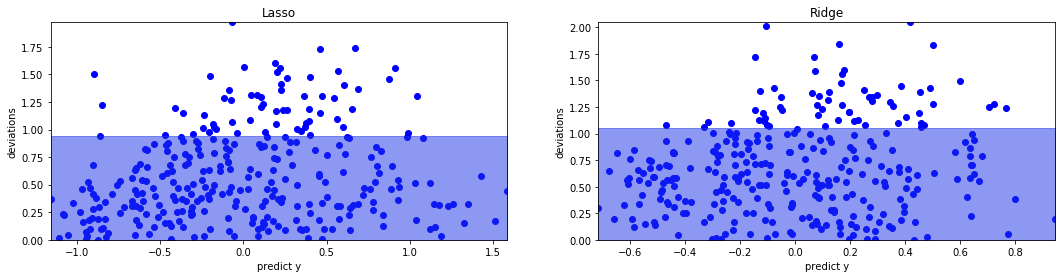

In [17]:
fig = plt.figure(figsize=(18, 4))

#--------Lasso
loss_abs = abs(y_train_pred_lasso - y_train_scaled)
limit = np.percentile(loss_abs, 80)
loss_Lasso_mask = loss_abs < limit

ax1 = fig.add_subplot(121)
ax1.scatter(y_train_pred_lasso,  loss_abs, c='blue', marker='o', label='Training data')
ax1.set(xlabel='predict y', ylabel='deviations', title='Lasso')

x = np.linspace(y_train_pred_lasso.min(), y_train_pred_lasso.max())
ax1.fill_between(x, limit, color= (0.1, 0.2, 0.9, 0.5))
ax1.set_xlim([y_train_pred_lasso.min(), y_train_pred_lasso.max()])
ax1.set_ylim([0.0, loss_abs.max()])

####--------Ridge
loss_abs = abs(y_train_pred_ridge - y_train_scaled)
limit = np.percentile(loss_abs, 80)
loss_Ridge_mask = loss_abs < limit

ax2 = fig.add_subplot(122)
ax2.scatter(y_train_pred_ridge,  loss_abs, c='blue', marker='o', label='Training data')
ax2.set(xlabel='predict y', ylabel='deviations', title='Ridge')

x = np.linspace(y_train_pred_ridge.min(), y_train_pred_ridge.max())
ax2.fill_between(x, limit, color= (0.1, 0.2, 0.9, 0.5))
ax2.set_xlim([y_train_pred_ridge.min(), y_train_pred_ridge.max()])
ax2.set_ylim([0.0, loss_abs.max()])

plt.show()

Распределение говорит нам, что предсказания добовольно сильно отличаются от настоящих значений. Синяя область сожержит нормальные значения, а белая - шумы. Считаем выбросами 20% объектов (то есть точность алгоритма зададим как 80%). Удалим шумы и обучим выборку:

In [18]:
y_train_right_lasso = y_train.loc[loss_Lasso_mask]
X_train_right_lasso = X_train.loc[loss_Lasso_mask]
y_train_right_ridge = y_train.loc[loss_Ridge_mask]
X_train_right_ridge = X_train.loc[loss_Ridge_mask]

In [19]:
sc_x = StandardScaler()
X_test_scaled = sc_x.fit_transform(X_test)
y_test_scaled = sc_x.fit_transform(y_test.to_frame()).flatten()

X_train_scaled_lasso = sc_x.fit_transform(X_train_right_lasso)
y_train_scaled_lasso = sc_x.fit_transform(y_train_right_lasso.to_frame()).flatten()

X_train_scaled_ridge = sc_x.fit_transform(X_train_right_ridge)
y_train_scaled_ridge = sc_x.fit_transform(y_train_right_ridge.to_frame()).flatten()

In [20]:
lasso = Lasso(alpha=0.01)

lasso.fit(X_train_scaled, y_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)
mse_1 = mean_squared_error(y_test_scaled, y_test_pred)

lasso.fit(X_train_scaled_lasso, y_train_scaled_lasso)
y_test_pred = lasso.predict(X_test_scaled)  
mse_2 = mean_squared_error(y_test_scaled, y_test_pred)

s = 'MSE до удаления выбросов: {:.3f} После: {:.3f} Увеличение на: {:.3f}'
print(s.format(mse_1, mse_2, mse_2 - mse_1))

MSE до удаления выбросов: 0.576 После: 0.588 Увеличение на: 0.011


In [21]:
ridge = Ridge(alpha=10)

ridge.fit(X_train_scaled, y_train_scaled)
y_test_pred = ridge.predict(X_test_scaled)
mse_1 = mean_squared_error(y_test_scaled, y_test_pred)

ridge.fit(X_train_scaled_ridge, y_train_scaled_ridge)
y_test_pred = ridge.predict(X_test_scaled)  
mse_2 = mean_squared_error(y_test_scaled, y_test_pred)

s = 'MSE до удаления выбросов: {:.3f} После: {:.3f} Увеличение на: {:.3f}'
print(s.format(mse_1, mse_2, mse_2 - mse_1))

MSE до удаления выбросов: 0.579 После: 0.632 Увеличение на: 0.053


Заметим, что качетсво стало только хуже. 

## Часть 2. Метод опорных векторов и калибровка вероятностней

Сгенерируем синтетические данные.

In [22]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Задание 1.** Обучение и применение метода опорных векторов.

**(1 балл)**

Обучим метод опорных векторов с помощью LinearSVC

In [23]:
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=0.1, max_iter=10000))
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

Матрица ошибок из себя представляет:

$
\begin{array}{l|c|r}
 & y = 1 & y = 0\\
\hline
a(x) = 1 & TP & FP \\
\hline
a(x) = 0 & FN & TN 
\end{array} 
$

Изучим подробнее матрицу ошибок.

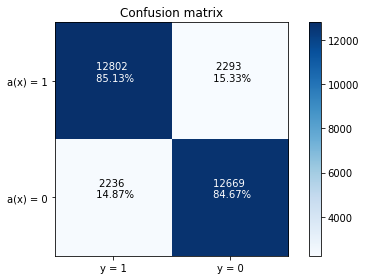

In [24]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_test_pred)
TP, FN, FP, TN = cm.flatten()
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.yticks([0, 1], ['a(x) = 1', 'a(x) = 0'])
plt.xticks([0, 1], ['y = 1', 'y = 0'])
   
max_ = cm.max() / 2.0
for i in (0, 1):
    for j in (0, 1):
        
        plt.text(i, j, '{} \n {:.2f}%'.format(cm[i, j], cm_norm[i, j]), horizontalalignment="center",
                color="white" if cm[i, j] > max_ else "black")

plt.tight_layout()
plt.show()

На тестовой части посчитаем ROC-AUC, PR-AUC. Построим ROC и PR кривые.

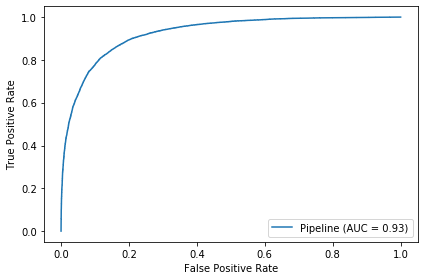

In [25]:
plot_roc_curve(clf, X_test, y_test)
plt.tight_layout()

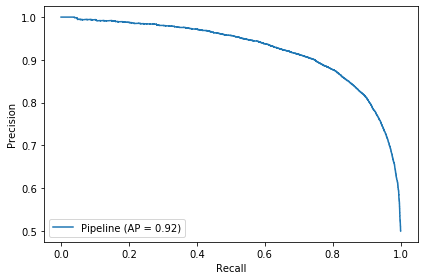

In [26]:
plot_precision_recall_curve(clf, X_test, y_test)
plt.tight_layout()

Итак, AUC = 0.93, a PR = 0.92

Сгенерируем синтетический датасет с помощью make_classification с 2 признаками (1000 объектов).

In [27]:
X, y = make_classification(n_samples=1000, n_features=2, n_clusters_per_class=1,
                           n_informative=1, n_redundant=0, random_state=42)
#X, y = make_blobs(n_samples=1000, centers=2, random_state=6)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Визуализируем данные.

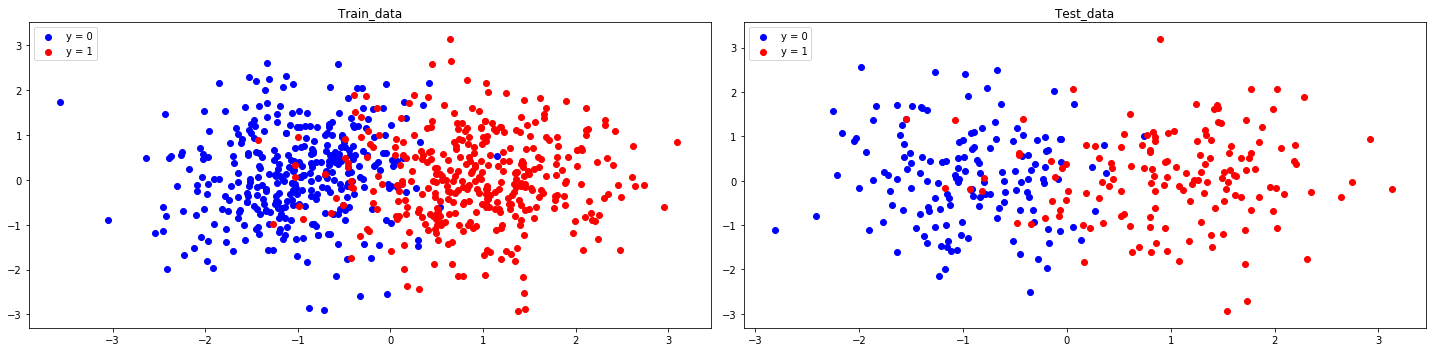

In [28]:
fig = plt.figure(figsize=(20, 5))

X_train_0, X_train_1 = X_train[y_train == 0], X_train[y_train == 1]
X_test_0, X_test_1 = X_test[y_test == 0], X_test[y_test == 1]

ax1 = fig.add_subplot(121)
ax1.set(title='Train_data')
ax1.scatter(X_train_0[:,0], X_train_0[:,1], c='blue', marker='o', label='y = 0')
ax1.scatter(X_train_1[:,0], X_train_1[:,1], c='red',  marker='o', label='y = 1')
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(122)
ax2.set(title='Test_data')
ax2.scatter(X_test_0[:,0], X_test_0[:,1], c='blue', marker='o', label='y = 0')
ax2.scatter(X_test_1[:,0], X_test_1[:,1], c='red',  marker='o', label='y = 1')
ax2.legend(loc='upper left')

plt.tight_layout()

Как видно, выборка "практически" линейно разделима (за исключением некоторых объектов-выбросов)

Обучим метод опорных векторов. В этот раз используем SVC kernel = linear вместо LinearSVC, так как только там есть информация об опорных векторах.

In [29]:
clf = SVC(kernel='linear', probability=True, C=0.1)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

Взглянем на матрицу ошибок:

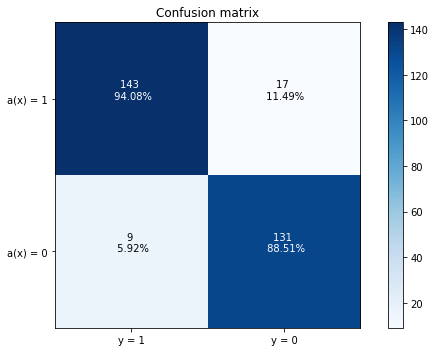

In [30]:
plt.figure(figsize=(8, 5))
cm = confusion_matrix(y_test, y_test_pred)
TP, FN, FP, TN = cm.flatten()
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.yticks([0, 1], ['a(x) = 1', 'a(x) = 0'])
plt.xticks([0, 1], ['y = 1', 'y = 0'])
   
max_ = cm.max() / 2.0
for i in (0, 1):
    for j in (0, 1):
        
        plt.text(i, j, '{} \n {:.2f}%'.format(cm[i, j], cm_norm[i, j]), horizontalalignment="center",
                color="white" if cm[i, j] > max_ else "black")

plt.tight_layout()
plt.show()

Визуализируем разделяющую прямую, все объекты и выделим опорные вектора. Зеленым градиентом обозначена степень уверенности в ответе (predict_proba)

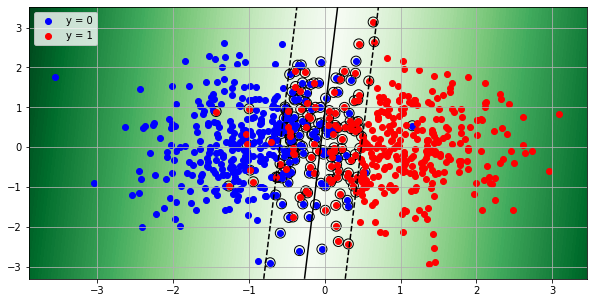

In [31]:
plt.figure(figsize=(10, 5))
plt.scatter(X_train_0[:,0], X_train_0[:,1], c='blue', label='y = 0')
plt.scatter(X_train_1[:,0], X_train_1[:,1], c='red',  label='y = 1')
plt.legend(loc='upper left')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1])
yy = np.linspace(ylim[0], ylim[1])
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=1, linestyles=['--', '-', '--'])
ax.contourf(XX, YY, abs(Z), 100, cmap='Greens', origin='lower')

ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.scatter(X_train_0[:,0], X_train_0[:,1], c='blue', label='y = 0')
plt.scatter(X_train_1[:,0], X_train_1[:,1], c='red',  label='y = 1')
plt.grid()
plt.show()

Построим калибровочные кривые для логистической регрессии и метода опорных векторов.

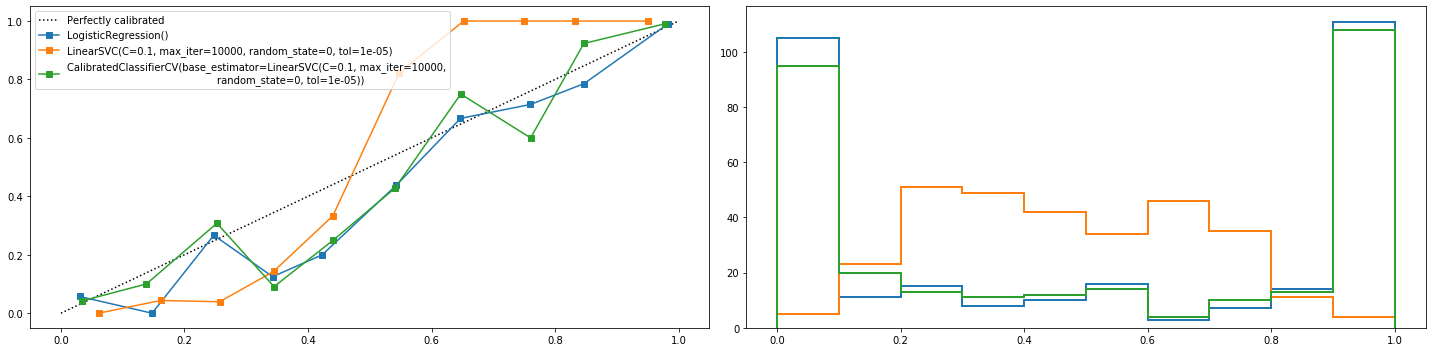

In [32]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(121)
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax2 = fig.add_subplot(122)
lr = LogisticRegression()
lsvc = LinearSVC(random_state=0, tol=1e-5, C=0.1, max_iter=10000)
clsvc = CalibratedClassifierCV(lsvc)

for clf in (lr, lsvc, clsvc):
    clf.fit(X_train, y_train)
    
    if hasattr(clf, "predict_proba"):
        pred_proba = clf.predict_proba(X_test)[:, 1]
    else: 
        pred_proba = clf.decision_function(X_test)
        pred_proba = (pred_proba - pred_proba.min()) / (pred_proba.max() - pred_proba.min())
        
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, pred_proba, n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label=clf)
    ax2.hist(pred_proba, range=(0, 1), bins=10, histtype="step", lw=2)
ax1.legend()
plt.tight_layout()

__Задание 2.__ Калибровка вероятностей.\
__(1.5 балла)__


Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. Изначально допущенные ошибки исправлены и помечены ##

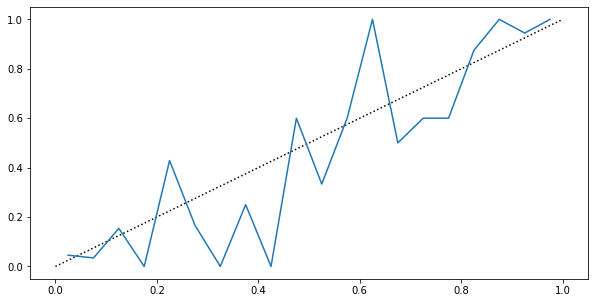

In [33]:
def plot_calibration_curve(y_test, preds, label=None):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) ##
        y_test_lr = y_test[(preds >= l) & (preds < r)] == 1
        bin_real_ratios.append(np.mean(y_test_lr.astype(int)) if y_test_lr.size else 0.0) ##
    plt.plot(bin_middle_points, bin_real_ratios, label=label)

plt.figure(figsize=(10, 5))
plt.plot([0, 1], [0, 1], "k:")
plot_calibration_curve(y_test, pred_proba)

Получившаяся кривая слабо приближает диагональ, к которой стремился бы график, будь вероятности откалибровны хорошо. 
Реализуем собственную функцию калибровки вероятностей на основе Platt Scaling. Будем оптимизировать функцию 
$P(y = 1|x) = \frac{1}{1 + e^{Ax + B}}$ по скалярным параметрам A,B c помощью GridSearchCV


**Бонусное задание (1 балл).** Реализуйте свою функцию для калибровки вероятностей.

In [34]:
B = np.arange(0, 2, 1)
A = np.arange(0, 2, 0.1)
BB, AA = np.meshgrid(B, A)
AB = np.vstack([AA.ravel(), BB.ravel()]).T
d = []
for A, B in AB:
    d.append({
        'A': A,
        'B': B
    })

In [35]:
predict_proba = []

ft = FunctionTransformer(lambda x, A, B: A * x + B)
lr = LogisticRegression()

clf = make_pipeline(ft, lr)
cv = KFold(n_splits=5, shuffle=True)
grid_param = {'functiontransformer__kw_args': d}
grid = GridSearchCV(estimator=clf, param_grid=grid_param, scoring='neg_mean_squared_error', cv=cv)
grid.fit(X_train, y_train)
predict_proba = grid.predict_proba(X_test)

Построим калибровочную кривую для нашего метода. 

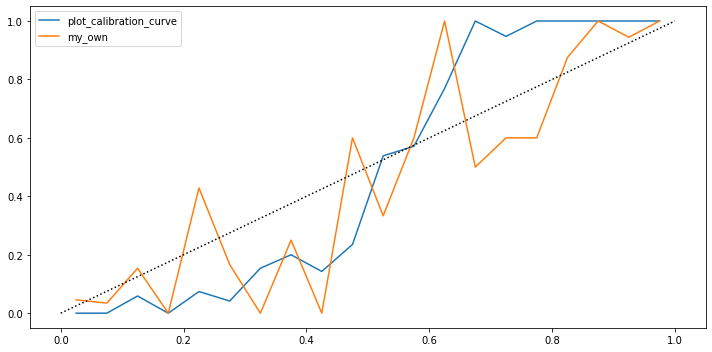

In [36]:
fig = plt.figure(figsize=(10, 5))
plot_calibration_curve(y_test, predict_proba[:,1], label='plot_calibration_curve')
plot_calibration_curve(y_test, pred_proba, 'my_own')
plt.plot([0, 1], [0, 1], "k:")
plt.legend()
plt.tight_layout()

Как видим, калибровочная кривая стала ближе к диагонали. То есть калибровка собственным методом работает.

## Часть 3. Логистическая регрессия.


__Задание 3.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.\
__(0.5 балла)__

Подготовим датасет.

In [37]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

In [38]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)
data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))
resampled_data = data.copy()

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)

Обучим логистическую регрессию. Сделаем предсказание на тестовой части выборки.

In [39]:
lr = LogisticRegression(solver='sag', max_iter=100, tol=1e-2, random_state=0)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
pred_proba = lr.predict_proba(X_test)

Построим ROC-кривую и Precision-Recall-кривую, посчитаем ROC-AUC и PR-AUC. 

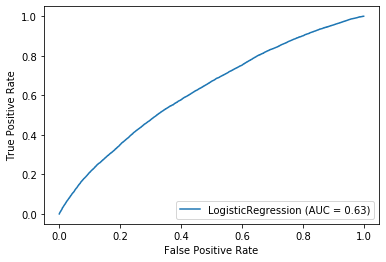

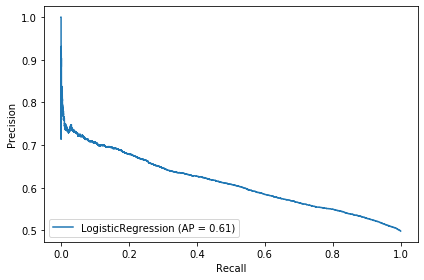

In [40]:
plot_roc_curve(lr, X_test, y_test)
plot_precision_recall_curve(lr, X_test, y_test)
plt.tight_layout()

Соответсвующие значения: AUC = 0.62, PR = 0.61

__Задание 4.__ Изучение влияния регуляризатора на процесс обучения

__(1 балл)__

Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, можно воспользоваться параметром `warm_start` у `sklearn.linear_model.LogisticRegression` либо методом `partial_fit` `sklearn.linear_model.SGDClassifier` (параметр `loss` тогда должен быть равен `log`).

Замечание:
* Для каждого $\alpha$ своя функция на графике; функции можно отображать на одном полотне **обязательно с легендой;** если $\alpha$ слишком много и на одном полотне они выглядят грязно, то можно строить на нескольких, однако в этом случае рекомендуется приводить масштаб и деления (min, max значения) на оси $y$ к одним  и тем же значениям --- так визуально будет очень просто сравнить графики и сделать выводы :)
* $\alpha$ желательно перебирать по **логарифмической шкале** (примерно как в первом задании), однако можно использовать информацию о том, что при некоторых значениях $\alpha$ модель не обучается хорошо и не исследовать их. Тут обязательно перебрать хотя бы 3 разных (степени в лог. шкале) $\alpha$, больше -- приветствуется.

Посмотрим, как влияет регуляризатор на функцию потерь. Для этого построим график зависимости LossFunc от коэффициента С от $10^{-3}$ и до $10^3$ с шагом в 0.5 по логарифмической шкале.

In [42]:
lr_results = []
for C in np.arange(-3, 3, 0.5):
    lr = LogisticRegression(C=np.power(10, C), solver='sag', max_iter=500, tol=1e-2, random_state=0)
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    
    lr_results.append({
        'C': C,
        'LossFunc_train': abs(mean_squared_error(y_train, y_train_pred) + 
                   LA.norm(lr.coef_) * C),
        'LossFunc_test': abs(mean_squared_error(y_test, y_test_pred) + 
                   LA.norm(lr.coef_) * C),
    })

In [43]:
def extract(results):
    C = []
    LF_train = []
    LF_test = []
    for r in results:
        C.append(r['C'])
        LF_train.append(r['LossFunc_train'])
        LF_test.append(r['LossFunc_test'])
    return C, LF_train, LF_test

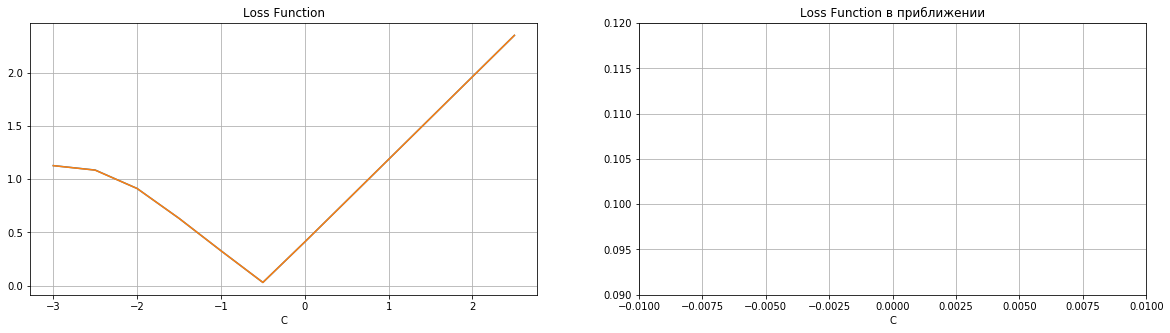

In [44]:
fig = plt.figure(figsize=(20, 5))
C, LF_train, LF_test = extract(lr_results)

ax1 = fig.add_subplot(121)
ax1.plot(C, LF_train, label='Train')
ax1.plot(C, LF_test, label='Test')
ax1.set(xlabel='C', title='Loss Function')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.set(xlim=(-0.01, 0.01), ylim=(0.09, 0.12), xlabel='C', title='Loss Function в приближении')
ax2.plot(C, LF_train)
ax2.plot(C, LF_test)
ax2.grid()

Как видно, наименьшее значение (0.903) функция потерь принимает при С = $10^{0} = 1.0$

## Часть 4. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

В этой части работаем с датасетом из предыдущей части.

__Задание 5.__ Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

__(0 баллов)__

In [47]:
def test_lr(plot_l_curve=False):

    global X_train, X_test, y_train, y_test
    
    start = time()
    lr = LogisticRegression(
        C=1/(10 ** 0.5),
        solver='sag',
        max_iter=500, tol=1e-2, 
        random_state=0,
    )
    
    if plot_l_curve:
        
        train_sizes, train_scores, validation_scores = learning_curve(
            lr, X_train, y_train, 
            train_sizes=np.linspace(0.1, 1.0, 10), 
            cv=4
        )
        
        fig, ax = plt.subplots()
        ax.plot(train_sizes, np.mean(train_scores, axis=1), linestyle='-', marker='o', label='Train curve')
        ax.fill_between(
            train_sizes, 
            np.min(train_scores, axis=1),
            np.max(train_scores, axis=1),
            alpha=0.3
        )

        ax.plot(train_sizes, np.mean(validation_scores, axis=1), linestyle='-', marker='o', label='Validation curve')
        ax.fill_between(
            train_sizes, 
            np.min(validation_scores, axis=1),
            np.max(validation_scores, axis=1),
            alpha=0.3
        )

        plt.xlabel('N of samples')
        plt.ylabel('Score')
        plt.legend()
        plt.show()

    lr.fit(X_train, y_train)
    print('Score: {:.4f}, done in {:.4f}s'.format(lr.score(X_test, y_test), time() - start))
    
    plot_roc_curve(lr, X_test, y_test)
    plot_precision_recall_curve(lr, X_test, y_test, response_method='predict_proba')
    plt.tight_layout()
    
    return lr

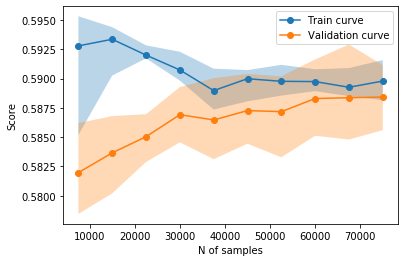

Score: 0.5896, done in 22.2631s


LogisticRegression(C=0.31622776601683794, max_iter=500, random_state=0,
                   solver='sag', tol=0.01)

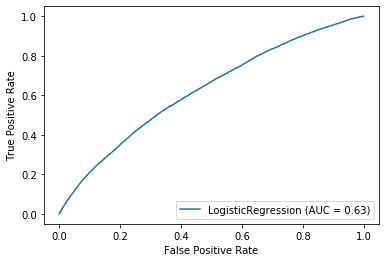

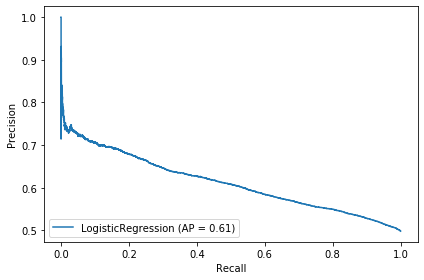

In [48]:
data = resampled_data.copy()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)
test_lr(True)

__Задание 6.__ 

Найдем все категориальные признаки:

In [49]:
data = resampled_data.copy()
categorical = data.columns[['cat' in name for name in data.columns]]

Закодируем с помощью one-hot-кодирования, предварительно обработав через labelEncoder.

In [50]:
le = LabelEncoder()   
ohe = OneHotEncoder(sparse=False)
data = data.reset_index(drop=True)
cat = data[categorical]
data_without_cat = data.drop(columns=categorical)
cat = cat.apply(LabelEncoder().fit_transform)
cat = pd.DataFrame(ohe.fit_transform(cat))
data = data_without_cat.join(cat)

data.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,173,174,175,176,177,178,179,180,181,182
0,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,6,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,10,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,9,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Разделим на те же обучающую и тестовую выборки:

Score: 0.5951, done in 4.7288s


LogisticRegression(C=0.31622776601683794, max_iter=500, random_state=0,
                   solver='sag', tol=0.01)

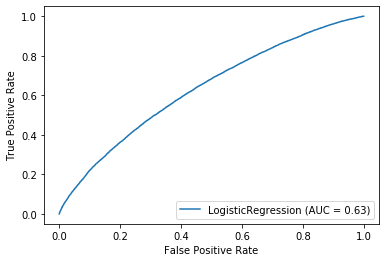

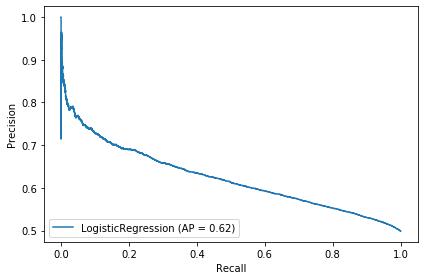

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)
test_lr()

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__(Бонусная часть)__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы. Не забудьте замерить время.

__(+0.5 балл)__

In [52]:
# restore resampled data
data = resampled_data.copy()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)

In [53]:
pd.set_option('mode.chained_assignment', None)

for cat in categorical:
    feature = np.empty(X_train[cat].shape)
    for val in np.unique(X_train[cat]):
        val_indices = (X_train[cat] == val)
        
        # extract targets and add some gauss noise
        val_targets = y_train[val_indices]
        mu, sigma = 0, 0.01
        noised_targets = val_targets + np.random.normal(mu, sigma, val_targets.shape)
        
        # add values to new feature column
        feature[val_indices] = np.mean(noised_targets)
        
        # add the new value to the X_test (there is no target leak!)
        X_test.at[X_test[cat] == val, cat] = np.mean(noised_targets)
    
    X_train.at[:, cat] = feature
    
X_train.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
1454056,0,0.541842,7,0.518840,0.482049,1,0,0,0,0,...,3,2,4,8,0,1,0,0,0,0
1066605,5,0.496897,6,0.518840,0.482049,0,0,0,1,0,...,3,2,2,6,1,0,0,0,0,1
1117456,1,0.496897,5,0.487423,0.482049,1,0,0,0,0,...,6,2,3,3,0,0,1,0,0,0
361122,1,0.502667,4,0.518840,0.482049,0,1,0,0,0,...,6,2,7,9,0,0,1,1,1,0
525574,0,0.510621,1,0.487423,0.482049,1,0,0,0,0,...,9,2,2,8,0,1,1,0,1,0


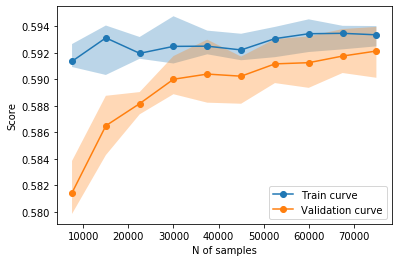

Score: 0.5924, done in 17.8055s


LogisticRegression(C=0.31622776601683794, max_iter=500, random_state=0,
                   solver='sag', tol=0.01)

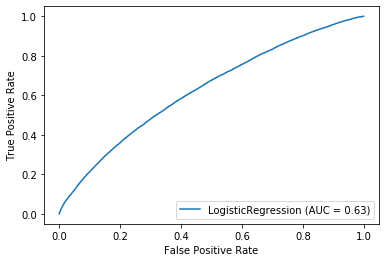

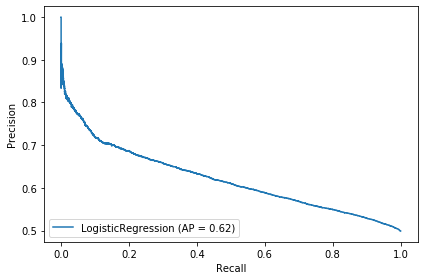

In [54]:
test_lr(True)

__(Бонусная часть)__ Посчитайте корректные счётчики, основываясь на объектах расположеных выше в датасете (не забудьте добавить и шум). 

__(+0.5 балла)__

Counters done in 0.603363037109375s


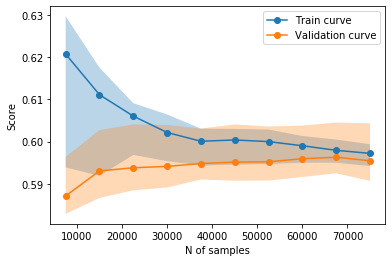

Score: 0.5909, done in 16.8806s


LogisticRegression(C=0.31622776601683794, max_iter=500, random_state=0,
                   solver='sag', tol=0.01)

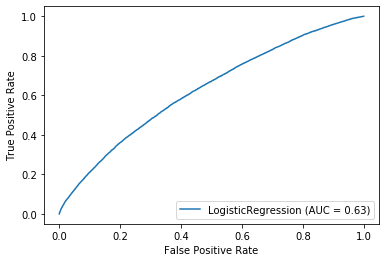

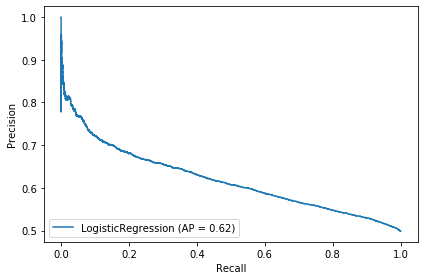

In [55]:
data = resampled_data.copy()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)

start = time()
for cat in categorical:
    
    feature = np.empty(X_train[cat].shape)

    for val in np.unique(X_train[cat]):
        indices = (X_train[cat] == val)
        means = np.cumsum(y_train[indices]) / (np.arange(y_train[indices].shape[0]) + 1)
        mu, sigma = 0, 0.01
        noised_means = means + np.random.normal(mu, sigma, means.shape)
        
        feature[indices] = noised_means

        # add the new value to the X_test (there is no target leak!)
        X_test.at[X_test[cat] == val, cat] = np.mean(noised_means)
            
    X_train[cat] = feature
    
print("Counters done in {}s".format(time() - start))
test_lr(True)

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$

где $global\_mean$ — среднее значение целевой переменной по всей выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значении. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

__Задание 7.__ Реализуйте счетчики со сглаживанием, как описано выше. Обучите логистическую регрессию, оцените качество.

__(0.5 балл)__

In [56]:
data = resampled_data.copy()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=42)


C = 10.0
for cat in categorical:
    feature = np.empty(X_train[cat].shape)
#     prior = np.mean(X_train[cat])
    prior = -1.0
    
    for val in np.unique(X_train[cat]):
        val_indices = (X_train[cat] == val)
        
        # extract targets and add some gauss noise
        val_targets = y_train[val_indices]
        mu, sigma = 0, 0.1
        noised_targets = val_targets + np.random.normal(mu, sigma, val_targets.shape)
        
        smooth_target = (sum(noised_targets) + C * prior) / (noised_targets.shape[0] + C)
        
        # add values to new feature column
        feature[val_indices] = smooth_target
        
        # add the new value to the X_test (there is no target leak!)
        X_test.at[X_test[cat] == val, cat] = smooth_target
    
    X_train.at[:, cat] = feature
    
X_train.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
1454056,0,0.537250,7,0.518139,0.481698,1,0,0,0,0,...,3,2,4,8,0,1,0,0,0,0
1066605,5,0.496748,6,0.518139,0.481698,0,0,0,1,0,...,3,2,2,6,1,0,0,0,0,1
1117456,1,0.496748,5,0.487368,0.481698,1,0,0,0,0,...,6,2,3,3,0,0,1,0,0,0
361122,1,0.494706,4,0.518139,0.481698,0,1,0,0,0,...,6,2,7,9,0,0,1,1,1,0
525574,0,0.509328,1,0.487368,0.481698,1,0,0,0,0,...,9,2,2,8,0,1,1,0,1,0


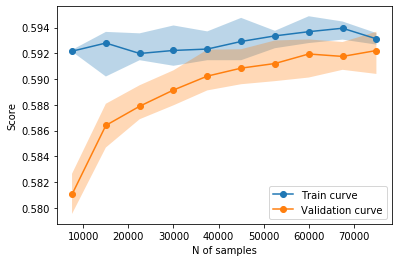

Score: 0.5924, done in 18.3987s


LogisticRegression(C=0.31622776601683794, max_iter=500, random_state=0,
                   solver='sag', tol=0.01)

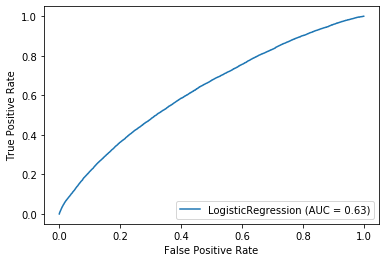

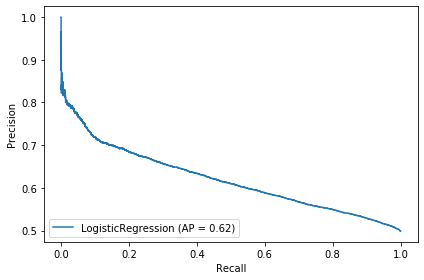

In [57]:
test_lr(True)

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием, вы заметили.

**Ответ:** В первую очередь, счётчики не увеличивают размеры датасета. Варьируя параметры шума, можно добиться хорошего значения снижения эффекта переобучения. Подсчёт корректных счётчиков занимает не слишком много времени и выполняется всего один раз для всего датасета. Однако, несмотря на ручной перебор некоторых параметров, не удалось добиться результата, превосходящего one-hot. Эту проблему частично решает введение счётчиков со сглаживанием и подбором параметра prior для каждой категории, вероятно с использованием grid_search. 

## Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [58]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [59]:
le = LabelEncoder()   
ohe = OneHotEncoder(sparse=False)
data = data.reset_index(drop=True)
cat = data[categorical]
data_without_cat = data.drop(columns=categorical)
cat = cat.apply(LabelEncoder().fit_transform)
cat = pd.DataFrame(ohe.fit_transform(cat))
data = data_without_cat.join(cat)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)
data.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,174,175,176,177,178,179,180,181,182,183
0,2,5,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,9,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


227 признаков

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

Score: 0.9637, done in 29.4404s


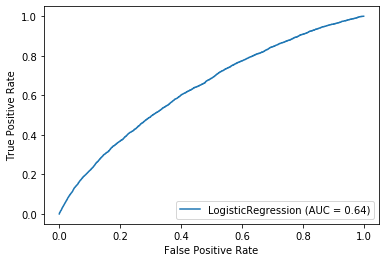

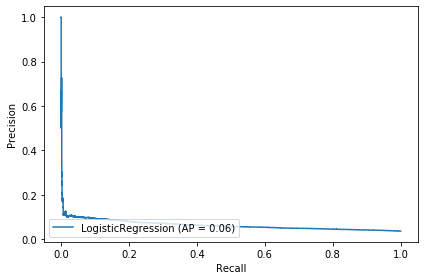

In [60]:
lr = test_lr()

Чудовищное падение average precision объясняется не менее чудовищным дисбалансом датасета:

In [61]:
np.mean(target)

0.036447517859182946

Более 96% датасета - это нулевые значения!

### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 8.__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков (время обучения нашего метода отбора).

Изменилось ли качество? Как?

__(0.5 балла)__

In [62]:
coefs = np.abs(lr.coef_.flatten())
indices = np.argsort(coefs)[-200:]
X_train = X_train.iloc[:, indices]
X_test = X_test.iloc[:, indices]

X_train.head()

,ps_calc_08,169,73,ps_ind_01,156,61,132,138,114,ps_calc_02,...,174,120,66,8,142,7,6,9,ps_car_13,ps_car_12
152538,9,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.8,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.661625,0.316070
531420,8,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.642824,0.316228
240868,10,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.741327,0.374166
253238,10,0.0,0.0,6,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.693848,0.374166
29833,8,0.0,0.0,3,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.663605,0.316228


Score: 0.9637, done in 15.4644s


LogisticRegression(C=0.31622776601683794, max_iter=500, random_state=0,
                   solver='sag', tol=0.01)

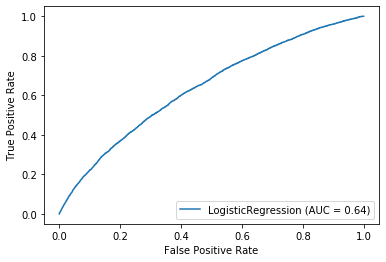

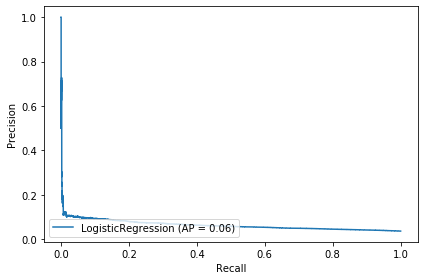

In [63]:
test_lr()

Качество модели в данном случае не изменилось, но это следует просто из её непригодности. Модель почти всегда предсказывает 0, так что ошибка осталась прежней. Однако время вычисления уменьшилось почти в два раза!

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [64]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

le = LabelEncoder()   
ohe = OneHotEncoder(sparse=False)
data = data.reset_index(drop=True)
cat = data[categorical]
data_without_cat = data.drop(columns=categorical)
cat = cat.apply(LabelEncoder().fit_transform)
cat = pd.DataFrame(ohe.fit_transform(cat))
data = data_without_cat.join(cat)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)
data.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,174,175,176,177,178,179,180,181,182,183
0,2,5,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,9,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
non_cat_columns = 57 - len(categorical)

means = np.mean(X_train[:non_cat_columns], axis=0)
X_train[:non_cat_columns] -= means
X_test[:non_cat_columns] -= means

var = 1.0 + np.var(X_train[:non_cat_columns], axis=0)
X_train[:non_cat_columns] /= var
X_test[:non_cat_columns] /= var

X_train.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,174,175,176,177,178,179,180,181,182,183
152538,-0.190887,0.307488,-0.266962,-0.197338,0.625170,-0.161578,0.0,0.0,-0.022739,0.0,...,0.0,0.0,0.0,-0.022739,-0.022739,0.0,0.0,0.0,-0.022739,-0.124577
531420,0.050529,-0.348147,-0.266962,-0.197338,-0.214902,0.706905,0.0,0.0,-0.022739,0.0,...,0.0,0.0,0.0,-0.022739,-0.022739,0.0,0.0,0.0,-0.022739,-0.124577
240868,-0.432302,-0.348147,0.552993,-0.197338,-0.214902,-0.161578,0.0,0.0,-0.022739,0.0,...,0.0,0.0,0.0,-0.022739,-0.022739,0.0,0.0,0.0,-0.022739,-0.124577
253238,1.016190,0.635305,-0.266962,0.651216,-0.214902,-0.161578,0.0,0.0,-0.022739,0.0,...,0.0,0.0,0.0,-0.022739,-0.022739,0.0,0.0,0.0,-0.022739,-0.124577
29833,0.291944,-0.020330,-0.266962,-0.197338,0.625170,-0.161578,0.0,0.0,0.955050,0.0,...,0.0,0.0,0.0,-0.022739,-0.022739,0.0,0.0,0.0,-0.022739,-0.124577


Score: 0.9637, done in 27.8822s


,156,34,114,ps_ind_01,132,ps_ind_08_bin,26,157,ps_calc_02,93,...,129,5,6,120,0,142,8,9,ps_car_13,ps_car_12
152538,0.0,-0.214902,0.0,-0.190887,0.0,0.625170,-0.022739,-0.022739,0.279323,0.0,...,0.0,0.0,0.372456,-0.044537,0.0,0.0,0.0,0.022739,-0.209660,-0.068606
531420,0.0,-0.214902,0.0,0.050529,0.0,-0.214902,-0.022739,-0.022739,0.279323,0.0,...,0.0,0.0,-0.428324,-0.044537,0.0,0.0,0.0,0.022739,-0.227149,-0.068448
240868,0.0,0.625170,0.0,-0.432302,0.0,-0.214902,-0.022739,-0.022739,0.095951,0.0,...,0.0,0.0,0.372456,-0.044537,0.0,0.0,0.0,0.022739,-0.135521,-0.010697
253238,0.0,-0.214902,0.0,1.016190,0.0,-0.214902,-0.022739,-0.022739,0.004264,0.0,...,0.0,0.0,-0.428324,-0.044537,0.0,0.0,0.0,0.022739,-0.179686,-0.010697
29833,0.0,0.625170,0.0,0.291944,0.0,0.625170,-0.022739,-0.022739,0.004264,0.0,...,0.0,0.0,-0.428324,-0.044537,0.0,0.0,0.0,0.022739,-0.207818,-0.068448


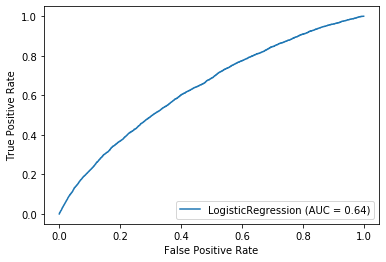

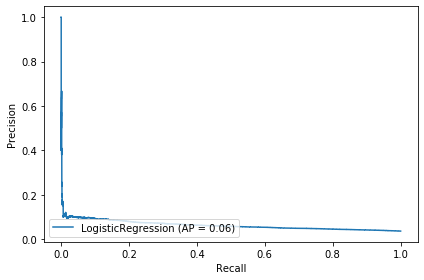

In [66]:
lr = test_lr()

coefs = np.abs(lr.coef_.flatten())
indices = np.argsort(coefs)[-200:]
X_train = X_train.iloc[:, indices]
X_test = X_test.iloc[:, indices]

X_train.head()

Score: 0.9637, done in 12.2155s


LogisticRegression(C=0.31622776601683794, max_iter=500, random_state=0,
                   solver='sag', tol=0.01)

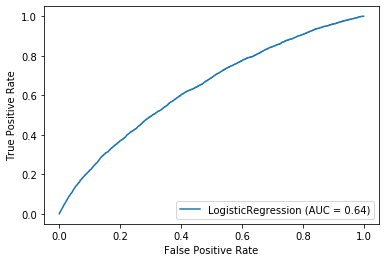

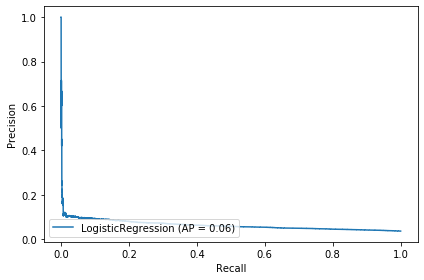

In [67]:
test_lr()

### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu_{+/-}$, $\sigma_{+/-}$, $n_{+/-}$ соответственно это --- среднее; среднеквадратичное отклонение; количество объектов каждого из классов.

__Задание 9.__ Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков (время обучения нашего метода отбора) в этом случаев.

__(0.5 балла)__

In [68]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

le = LabelEncoder()   
ohe = OneHotEncoder(sparse=False)
data = data.reset_index(drop=True)
cat = data[categorical]
data_without_cat = data.drop(columns=categorical)
cat = cat.apply(LabelEncoder().fit_transform)
cat = pd.DataFrame(ohe.fit_transform(cat))
data = data_without_cat.join(cat)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)
data.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,174,175,176,177,178,179,180,181,182,183
0,2,5,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,9,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
class_A = X_train[y_train == 1]
class_B = X_train[y_train == 0]

n_A = class_A.shape[0]
n_B = class_B.shape[0]

mean_A = np.mean(class_A, axis=0)
mean_B = np.mean(class_B, axis=0)

var_A = np.var(class_A, axis=0)
var_B = np.var(class_B, axis=0)

T = np.abs(mean_A - mean_B) / np.sqrt((n_A * var_A + n_B * var_B) / (n_A + n_B))

In [71]:
indices = np.argsort(T)[-200:]
X_train = X_train.iloc[:, indices]
X_test = X_test.iloc[:, indices]

X_train.head()

,108,80,170,138,3,94,20,177,77,162,...,ps_reg_03,68,ps_ind_07_bin,ps_ind_06_bin,ps_reg_02,35,9,ps_ind_17_bin,ps_car_12,ps_car_13
152538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.557898,1.0,0,0,0.2,1.0,1.0,0,0.316070,0.661625
531420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.943729,1.0,0,0,0.9,1.0,1.0,0,0.316228,0.642824
240868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.637868,1.0,0,1,0.4,1.0,1.0,1,0.374166,0.741327
253238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,1.0,1,0,0.0,1.0,1.0,0,0.374166,0.693848
29833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.184800,1.0,0,0,0.0,1.0,1.0,0,0.316228,0.663605


Score: 0.9637, done in 22.7201s


LogisticRegression(C=0.31622776601683794, max_iter=500, random_state=0,
                   solver='sag', tol=0.01)

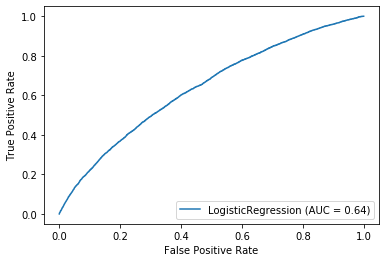

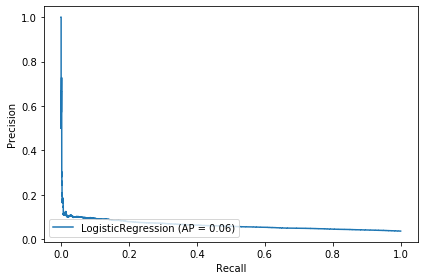

In [72]:
test_lr()

### Методы-обёртки

__Задание 10.__ 

__(1 балл)__

Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо. 

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [73]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

le = LabelEncoder()   
ohe = OneHotEncoder(sparse=False)
data = data.reset_index(drop=True)
cat = data[categorical]
data_without_cat = data.drop(columns=categorical)
cat = cat.apply(LabelEncoder().fit_transform)
cat = pd.DataFrame(ohe.fit_transform(cat))
data = data_without_cat.join(cat)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

In [74]:
np.random.seed(42)
global_start = time()
while X_train.shape[1] > 200:
    start = time()
    
    
    # get a sample
    mask_plus = np.random.choice(np.where(y_train == 1)[0], 5000, replace=True)
    mask_zero = np.random.choice(np.where(y_train == 0)[0], 5000, replace=True)
    sample = pd.concat((X_train.iloc[mask_plus], X_train.iloc[mask_zero]))
    sample_target = np.hstack((y_train[mask_plus], y_train[mask_zero]))
    
    mask_plus = np.random.choice(np.where(y_train == 1)[0], 2000, replace=True)
    mask_zero = np.random.choice(np.where(y_train == 0)[0], 2000, replace=True)
    test_sample = pd.concat((X_train.iloc[mask_plus], X_train.iloc[mask_zero]))
    test_sample_target = np.hstack((y_train[mask_plus], y_train[mask_zero]))
    
    
    # remove columns
    columns = np.array(sample.columns)
    np.random.shuffle(columns)
    columns = np.array_split(columns, len(columns) // 5 + 1)
    
    score = 0
    for cols in columns:
        
        lr = LogisticRegression(
            solver='sag',
            max_iter=500, tol=1e-2, 
            random_state=0,
        )
        
        lr.fit(sample.drop(cols, 1), sample_target)
        cur_score = roc_auc_score(test_sample_target, lr.predict(test_sample.drop(cols, 1)))
        
        if cur_score > score:
            columns = cols
            score = cur_score
    
    sample = sample.drop(columns, 1)
    X_train = X_train.drop(columns, 1)
    X_test = X_test.drop(columns, 1)
    
    print('Remove {} (score is {:.4f}, time for iteration = {:.4f}s)'.format(columns, score, time() - start))
    
print("Done in {:.4f}s".format(time() - global_start))

Remove [41 50 'ps_car_11' 9 'ps_calc_03'] (score is 0.5842, time for iteration = 25.4470s)
Remove [71 154 'ps_calc_02' 148] (score is 0.5950, time for iteration = 19.4488s)
Remove [91 163 66 'ps_calc_15_bin' 80] (score is 0.5845, time for iteration = 18.5240s)
Remove ['ps_ind_07_bin' 'ps_reg_03' 'ps_ind_16_bin' 25 64] (score is 0.5907, time for iteration = 22.3400s)
Remove [144 103 'ps_ind_14' 'ps_ind_12_bin' 18] (score is 0.5787, time for iteration = 15.6834s)
Remove [28 12 38 27 151] (score is 0.5837, time for iteration = 18.5327s)
Done in 119.9778s


Score: 0.9637, done in 20.4696s


LogisticRegression(C=0.31622776601683794, max_iter=500, random_state=0,
                   solver='sag', tol=0.01)

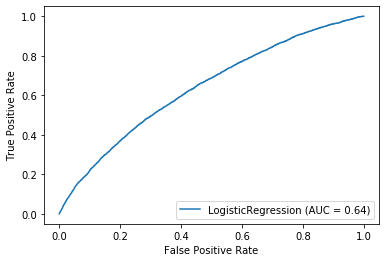

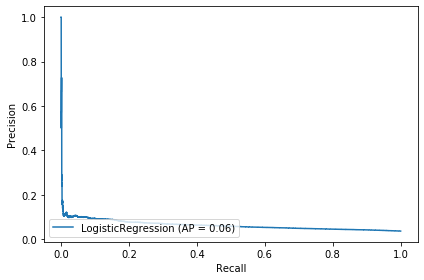

In [75]:
test_lr()

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Очень сложно аккуратно оценить качество каждого метода, поскольку регрессия остаётся прежней при использовании любого из них (этот эффект наблюдается из-за не сбалансированности датасета: в предыдущем задании сэмплирование помогало избавиться от этого эффекта, но сейчас модель стабильно выдаёт значения, близкие к нулю вне зависимости от входных данных). Те же эксперементы я провела для сэмплированного датасета, и могу сделать следующие выводы: методы фильтрации требуется аккуратно подбирать под задачу, поскольку они крайне не универсальны и не учитывают характер данных и влияние их на модель; методы, построенные на последовательном "вычёркивании" признаков с наименьшей значимостью или одновременной оценке на обученной модели (с отнормированными признаками) показывают себя лучше всего, поскольку учитывают особенности датасета и самой модели.

## Настройка порога для бинаризации вероятностей

В этой части мы будем проделывать стандартные операции для подготовки модели к её реальному использованию — подбора порога для бинаризации вероятностей с учётом потребностей бизнеса или продукта. Хороший алгоритм с точки зрения ROC-AUC это, конечно, хорошо, но ведь в реальности нам надо принимать решение бинарно, например, выдавать ли кредит человеку. 

Воспользуемся той же самой задачей, что и в предыдущем разделе — определение обращение клиента в страховую в ближайшее время. Положительные объекты в нашей выборки как раз обратившиеся в страховую клиенты. 

Не вдаваясь в подробности бизнеса страховых, можно понять, что обращение клиента по страховому случаю для нас как страховой невыгодно, ведь мы теряем на этом деньги. Клиенты, которые не обращаются в страховую и ездят аккуратно, приносят нам деньги.

Пусть на каждом клиенте, который обратился в нашу страховую, мы теряем 100000, а на клиенте, который не обратился в страховую, мы зарабатываем 5000. 

Будем строить алгоритм, который прогнозирует обращение по страховому случаю, чтобы некоторым потенциальным клиентам отказывать в обслуживании, если мы уверены, что на них мы потеряем деньги.

In [76]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

В этот раз мы не будем сэмплировать данные и будем использовать их "как есть".

Посчитайте долю положительных примеров в выборке? Скажите, почему она такая?

In [77]:
np.mean(target)

0.036447517859182946

Поскольку в страховых компаниях работают ~~ушлые~~ умные люди, которые умеют считать свою прибыль, предположим, что доход с клиентов должен перекрывать убытки. Найдём число клиентов, которые не должны обратиться в страховую, чтобы заработок от них перекрывал убыток от одного обратившегося:

$$
    100000 < 5000 * n \Rightarrow n > 100000 / 5000 = 20
$$

То есть на каждого убыточного клиента должно приходится хотя бы 20 "хороших". <br>
Доля таких клиентов составляет приблизительно 0.9523. Это означает, что при формировании цен страховая компания провела исследование и выяснила, что примерно 95 процентов водителей будут приносить прибыль. То есть в интересах компании отказывать тем четырём процентам, которые потенциально могут стать убыточными, но не упустить те 95%, которые будут приносить доход. <br>
Отсюда и такое соотношение отказов.

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить.

In [78]:
le = LabelEncoder()   
ohe = OneHotEncoder(sparse=False)
data = data.reset_index(drop=True)
cat = data[categorical]
data_without_cat = data.drop(columns=categorical)
cat = cat.apply(LabelEncoder().fit_transform)
cat = pd.DataFrame(ohe.fit_transform(cat))
data = data_without_cat.join(cat)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

В качестве нашей основной модели будем использовать логистическую регрессию, которая возвращает вероятность положительного класса. Обучите модель, сделайте предсказания на тестовой выборке.

Score: 0.9637, done in 29.0734s


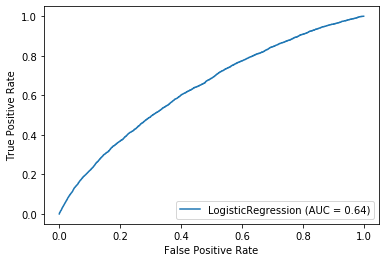

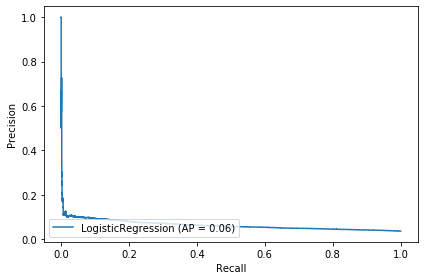

In [79]:
lr = test_lr()
y_pred = lr.predict_proba(X_test)

Посчитайте ROC-AUC. Что вы можете про него сказать? Как вы считаете, почему получилось так?

Постройте precision-recall кривую на тестовой выборке. Что вы можете по ней сказать?

Как уже и было написано выше, модель просто выдаёт страховку всем подряд, почти никому не отказывая. К этому приводит дисбаланс классов. 
Мы фактически не отказываем никому, даже тем, кто попадает в четыре процента "плохих" клиентов для страховой компании. 

У нас есть алгоритм, который определяет вероятность обращения клиента по страховому случаю, но мы хотим использовать этот алгоритм, чтобы отказывать клиентам в обслуживании в страховой. Для этого нам нужны бинарные предсказания алгоритма. Давайте искать этот порог для получения бинарных предсказаний.

__Задание 11.__

__(0.5 балла)__

Предположим, что нам надо подобрать порог такой, чтобы среди наших положителных предсказаний 95\% действительно обратились бы по страховому случаю. Подберите соответствующий порог, оцените на нём precision, recall. Скажите, какой части потенциальных клиентов мы откажем?

In [80]:
y_pred

array([[0.8469, 0.1531],
       [0.9595, 0.0405],
       [0.9647, 0.0353],
       ...,
       [0.9681, 0.0319],
       [0.9659, 0.0341],
       [0.9737, 0.0263]])

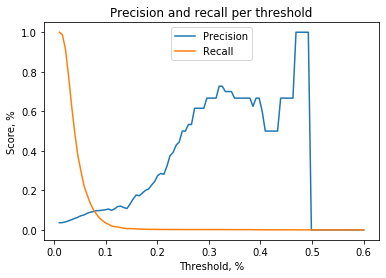

In [81]:
threshold = np.linspace(0.01, 0.6, 100)
presicion = []
recall = []

for value in threshold:
    bin_preds = (y_pred[:, 1] > value).astype(int)
    presicion.append(precision_score(y_test, bin_preds, zero_division=0))
    recall.append(recall_score(y_test, bin_preds))
    
plt.title('Precision and recall per threshold')
plt.xlabel('Threshold, %')
plt.ylabel('Score, %')
plt.plot(threshold, presicion, label='Precision')
plt.plot(threshold, recall, label='Recall')
plt.legend()
plt.show()

In [82]:
min_threshold = np.where(np.array(presicion) > 0.95)[0][0]
print("Recall for this threshold is", recall[min_threshold])

Recall for this threshold is 0.00023142791020597085


In [83]:
pred = (y_pred[:, 1] > threshold[min_threshold]).astype(int)
np.mean(pred[y_test == 0])

0.0

Мы никому не отказали при таком пороге, зато "нахватали" клиентов, которые принесут убытки.

Иногда сложно решить, какие значения precision и recall нужны в нашей задаче. Однако иногда можно оценить экономический эффект от нашего алгоритма. Мы знаем, во сколько нам обходится клиент, который обратился в страховую, и сколько нам приносит клиент, который не обратился. 

При фиксированном пороге мы знаем, кому мы бы отказали в обслуживании. Среди них есть те, кто обратился бы в страховую и нам пришлось бы потратить деньги, и те, кто не обратился бы, то есть принёс бы нам деньги. Мы можем посчитать разницу между нашими доходами и расходами от этой группы людей и надеяться, что она будет положительной. 

__Задание 12.__ Найдите такой порог, при котором наш баланс (разница между доходами и расходами на группе клиентов, которым мы отказали) неотрицательный. 

__(1 балл)__

In [84]:
gain = 5000
loss = 100000

total = []
negatives = []
for val in threshold:
    pred = (y_pred[:, 1] > val).astype(int)
    TN = sum(pred[y_test == 1])
    FN = sum(pred[y_test == 0])
    negatives.append(TN + FN)
    total.append(TN * loss - FN * gain)

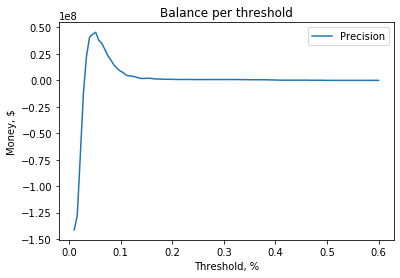

In [85]:
plt.title('Balance per threshold')
plt.xlabel('Threshold, %')
plt.ylabel('Money, $')
plt.plot(threshold, total, label='Precision')
plt.legend()
plt.show()

А на каком значение порога это разница максимальна? Скольким клиентам мы отказали в обслуживании?

In [86]:
best_i = np.argmax(total)
print("Best threshold is {:.4f}; {} clients was dropped".format(
    threshold[best_i],
    negatives[best_i]
))

Best threshold is 0.0517; 18180 clients was dropped


## Часть 5 (бонус). Vowpal Wabbit

В этой части мы научимся использовать библиотеку [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit). У неё есть несколько особенностей:
- можно обучать только линейные модели, но за счёт большого количества опций и возможностей по усложнению, можно построить и довольно сложные вещи
- можно обучаться на выборках, которые не помещаются в оперативную память
- можно обрабатывать большое количество признаков (например, мешки слов текстов) и "на ходу" строить на них комбинации (не переделывать датасет)
- другие особенности, как например, активное обучение и возможность распараллеленного обучения.

Основные особенности при использовании следующие:
- Свой формат данных: "label |A feature1:value1 |B feature2:value2", позволяющий, во-первых, указывать не все признаки (не нужно хранить много нулей в разреженных данных), а во-вторых, группировать и иметь возможность отключать или взаимодействовать ("отключать", добавлять квадратичные признаки и т.д.) сразу со всей группой признаков. По этой причине вам понадобится реализовать конвертер датасета и загрузку своих предсказаний, чтобы посчитать качество предсказаний.
- Запуск обучения из командной строки (однако можно запускать эти же команды из ноутбука).

В этот раз мы будем использовать данные с конкурса [Kaggle Avazu Click-Through Rate Prediction](https://www.kaggle.com/c/avazu-ctr-prediction) по предсказанию кликов (бинарная классификация). В обучающей выборке 40kk строк, так что у вас не должно быть желания загружать их в оперативную память. Предлагается взять первые 30kk строк в качестве обучающей выборке и оставшуюся часть для тестирования.

<font color="red"> !!ВНИМАНИЕ!! ХАЛЯВНЫЕ БАЛЛЫ!! ЗАДАНИЕ НА 0.5 БАЛЛА НЕСЛОЖНОЕ И ОЧЕНЬ ПОЛЕЗНОЕ!!</font>

__Задание 13.__ Работа с vowpal wabbit. 

- Скачайте данные, разделите их на обучающую и тестовую выборки.
- Подготовьте функции для конвертирования датасета в формат vowpal wabbit и для загрузки предсказаний в ноутбук для подсчёта функционала.
- Сделайте простейшее решение на vowpal wabbit. Оцените качество.
- Изучите возможности и параметры vowpal wabbit. Поэксперементируйте. 
- Расскажите, что интересного вы узнали (какие-нибудь особенности, режимы работы, фишки, параметры).
- Удалось ли вам улучшить качество базовой модели? Насколько? Что ещё можно было бы попробовать?

В этом задании предусмотрены баллы по двум критериям:
- Мы видим, что вы **"поигрались" с vw**, а именно: запуск vw, обучение модели и предсказание ответов на нашем датасете (2-3 попытки обучения с разными параметрами, если не достигли 0.738), изменение значения/включения/выключения 2-3 параметров обучения с описанием того, что они делают. Несколько занимательных фактов и возможностей vowpal-wabbit __(0.5 балла)__.
- Достижение ROC-AUC на отложенной выборки более 0.738 __(1 балл)__

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ